In [1]:
# IMPORT LIBRARIES #
import pandas as pd
import pygsheets
import numpy as np

In [2]:
# FLAGS #

#Set to 1 to print diagnostic info
debugFlag = 0
#Set to 1 to pull info from RawNames sheet, join GPS, update, and export
updateGPSFlag = 1

In [3]:
# IMPORT DATA #

gc = pygsheets.authorize(service_file='file.json')
sh = gc.open('DashData')

if debugFlag:
    for x in sh:
        print(x)

for x in sh:
    title = x.title
    if(title=="DeliveriesOld"):
        import_sheets_OldDelDF = x.get_as_df()
    elif(title=="Deliveries"):
        import_sheets_DelDF = x.get_as_df()
    elif(title=="Days"):
        import_sheets_DaysDF = x.get_as_df()
    elif(title=="Weeks"):
        import_sheets_WeeksDF = x.get_as_df()
    elif(title=="RawNames"):
        import_sheets_RawNamesDF = x.get_as_df()
    elif(title=="GPS"):
        #for import
        import_sheets_GPSDF = x.get_as_df()
        #for export
        if updateGPSFlag:
            import_wks_gps = x
    else:
        print("Worksheet not stored: ", x)

Worksheet not stored:  <Worksheet 'Import' index:6>
Worksheet not stored:  <Worksheet 'Lifetime Deliveries' index:7>
Worksheet not stored:  <Worksheet 'Days Old' index:8>
Worksheet not stored:  <Worksheet 'Weeks Old' index:9>


In [4]:
# Allows for disjoint cells, one for import, one for reset to import value (for ease of testing)

#DF from sheets
sheets_OldDelDF   = import_sheets_OldDelDF.copy()
sheets_DelDF      = import_sheets_DelDF.copy()
sheets_DaysDF     = import_sheets_DaysDF.copy()
sheets_WeeksDF    = import_sheets_WeeksDF.copy()
sheets_RawNamesDF = import_sheets_RawNamesDF.copy()
sheets_GPSDF      = import_sheets_GPSDF.copy()

In [5]:
# FUNCTIONS #

def processStacks(df):
    df["Stack Encoding"] = 0 
    for index, row in df.iterrows():
        if type(row["Stacked"]) == int:
            df.at[index, "Stack Encoding"] = 2
            df.at[index, "Distance"] /= 2
            df.at[index, "Duration"] /= 2
        else:
            if (row["Stacked"] == ""):
                df.at[index, "Stack Encoding"] = 1
            elif (row["Stacked"] == "PENTA"):
                df.at[index, "Stack Encoding"] = 5
                df.at[index, "Distance"] /= 5
                df.at[index, "Duration"] /= 5
            elif (row["Stacked"] == "QUAD"):
                df.at[index, "Stack Encoding"] = 4
                df.at[index, "Distance"] /= 4
                df.at[index, "Duration"] /= 4
            else:
                df.at[index, "Stack Encoding"] = 3
                df.at[index, "Distance"] /= 3
                df.at[index, "Duration"] /= 3

def dollars_to_floats(df, columns):
    for x in columns:
        df[x] = df[x].str.replace('$', '')
        df[x] = df[x].str.replace(',', '')
        df[x] = df[x].astype(float)
        
def hours_to_floats(df, columns):
    for x in columns:
        for index, row in df.iterrows():
            active = row[x]
            activeH = float(active[:active.index(":")])
            activeM = round(float(active[active.index(":")+1:active.index(":")+3])/60, 2)
            active = activeH + activeM
            df.at[index, x] = active
        df[x] = df[x].astype(float)

def getStartHour(df):
    df["Start Hour"] = -1
    for index, row in df.iterrows():
        startHour = row["Start Time"]
        clockSet = startHour[-2]
        startHour = int(startHour[:startHour.index(":")])
        if (clockSet == "P"):
            startHour += 12
        df.at[index, "Start Hour"] = startHour

def getStartHour2(df):
    df["Start Hour2"] = -1
    for index, row in df.iterrows():
        startHour = row["Start Time"]
        clockSet = startHour[-2]
        startHour = int(startHour[:startHour.index(":")])
        if (clockSet == "P"):
            startHour += 12
        df.at[index, "Start Hour2"] = startHour        
        

def addStartAndEndDate(df):
    lastRow = df.iloc[[-1]]
    df = df[:-1]
    df["Start Date"] = -1
    df["End Date"]   = -1
    for index, row in df.iterrows():
        tempVar = row["Dates"]
        tempVar1 = tempVar[:tempVar.index(" ")]
        tempVar2 = tempVar[tempVar.index("- ")+2:]
        df.at[index, "Start Date"] = tempVar1
        df.at[index, "End Date"] = tempVar2
    df = pd.concat([df, lastRow], ignore_index=True)
    df.reset_index(drop=True, inplace=True)
    return df

#Currently only valid for 2023
def date_to_datetime(df, column):
    for index, row in df.iterrows():
        df.at[index, column] = pd.Timestamp('2023/' + row[column])
    df[column] = pd.to_datetime(df[column])
        
        
#Currently only valid for 2023
# Currently unused function
# Would we actually want this to have different dates? it's really the date the shift started
# So maybe, keep date same, but certain analysis might require that difference to be handled
def time_to_timestamp(df, DateCol, TimeCols):
    for index, row in df.iterrows():
        df.at[index, TimeCols[0]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[0]])
        df.at[index, TimeCols[1]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[1]])

In [6]:
# UPDATE GPS WORKSHEET #

if updateGPSFlag:
    testingDF = sheets_RawNamesDF.copy()
    testingDF = testingDF.drop_duplicates(subset=["Restaurant Name", "RAW DATA"])
    testingDF = testingDF[["Restaurant Name", "RAW DATA", "Note"]]
    newNamesDF = testingDF.merge(sheets_GPSDF, how='left')
    for index, row in newNamesDF.iterrows():
        if isinstance(row['Address'], float):
            if not row['Note'] == "":
                newNamesDF.at[index, "Address"] = row["Note"]
            else:
                print("Note not found for:", index)
        if (row['Address'] == ""):
            newNamesDF.at[index, "Resolved"] = "0"
        else:
            newNamesDF.at[index, "Resolved"] = "1"
    newNamesDF = newNamesDF.drop(columns=["Note"])
    import_wks_gps.set_dataframe(newNamesDF,(1,1))

In [7]:
# START PROCESSING #

In [8]:
# FUNCTIONS AND OTHER SHORT PROCESSING STEPS #


#V1/V2
dollars_to_floats(sheets_OldDelDF, ["Total", "Base", "Tip", "Peak Bonus"])
date_to_datetime(sheets_OldDelDF, "Date")
sheets_OldDelDF["Day of Week"] = sheets_OldDelDF["Date"].dt.day_name()
#V3 only
dollars_to_floats(sheets_DelDF, ["Total", "Base", "Tip", "Peak Bonus"])
getStartHour(sheets_DelDF)
date_to_datetime(sheets_DelDF, "Date")
sheets_DelDF["Day of Week"] = sheets_DelDF["Date"].dt.day_name()
processStacks(sheets_DelDF)
#Days
dollars_to_floats(sheets_DaysDF, ["Total", "Base", "Tip"])
hours_to_floats(sheets_DaysDF, ["Dash", "Active"])
date_to_datetime(sheets_DaysDF, "Date")
sheets_DaysDF["Day of Week"] = sheets_DaysDF["Date"].dt.day_name()
sheets_DaysDF["HourlyRate"] = sheets_DaysDF["Total"]/sheets_DaysDF["Dash"]
#Weeks
dollars_to_floats(sheets_WeeksDF, ["Total", "Base", "Tip", "Adj pay", "Other", "Pre Total"])
hours_to_floats(sheets_WeeksDF, ["Dash", "Active"])
sheets_WeeksDF = addStartAndEndDate(sheets_WeeksDF)
# pretotalactiveratio refers to weekly pre adjustment pay / time spent on deliveries
sheets_WeeksDF["pretotalactiveratio"] = round(sheets_WeeksDF["Pre Total"]/sheets_WeeksDF["Active"], 2)
sheets_WeeksDF["HourlyRate"] = sheets_WeeksDF["Total"]/sheets_WeeksDF["Dash"]

/tmp/ipykernel_5370/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5370/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5370/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5370/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular

In [9]:
# V3 SELECTION #
sheets_DaysDF1 = sheets_DaysDF[sheets_DaysDF["Version"] == 3].copy()
sheets_WeeksDF1 = sheets_WeeksDF[sheets_WeeksDF["Version"] == 3].copy() #totals doesn't have v3 so its dropped

In [10]:
# ACTIVE MILEAGE 
#tempDF = sheets_DelDF
tempDF = sheets_DelDF.groupby(["Date"]).agg({"Distance": "sum"})
tempDF = tempDF.rename(columns={"Distance": "ActiveMileage"})
sheets_DaysDF1 = sheets_DaysDF1.merge(tempDF, on=['Date', sheets_DaysDF1.index])
sheets_DaysDF1 = sheets_DaysDF1.drop(columns=['key_1'])
tempDF = sheets_DaysDF1.groupby(["WeekID"]).agg({"ActiveMileage": "sum"})
sheets_WeeksDF1 = sheets_WeeksDF1.merge(tempDF, on=['WeekID', sheets_WeeksDF1.index])
sheets_WeeksDF1 = sheets_WeeksDF1.drop(columns=['key_1'])

In [11]:
# BEGIN ADJ PAY SECTION (v3 only) #

# This establishes the estimated pay adjustment estimates by delivery, date, and week
# This is calculated using time spent delivering and distance approximations
# The real adjusted pay is based on weekly values
# I suspect the primary cause for difference between estimate and real values stems from 
#how I estimate mileage vs how the app tracks mileage

In [12]:
#Per delivery estimations


sheets_DelDF["Duration"] = pd.to_numeric(sheets_DelDF["Duration"])
sheets_DelDF["Est Adj"] = (sheets_DelDF["Duration"]/60*18
                           + sheets_DelDF["Distance"]*(0.34) ) - sheets_DelDF["Base"]
#Duration is over 60 because its value is in minutes, values from day and week are in hours

In [13]:
#Per day estimations
sheets_DaysDF1["Est Adj"] = (sheets_DaysDF1["Active"]*(18) 
                            + sheets_DaysDF1["ActiveMileage"]*(0.34) ) - sheets_DaysDF1["Base"]

In [14]:
#Per week estimations
sheets_WeeksDF1["Est Adj"] = (sheets_WeeksDF1["Active"]*(18) 
                            + sheets_WeeksDF1["ActiveMileage"]*(0.34) ) - sheets_WeeksDF1["Base"]

In [15]:
# END ADJ PAY SECTION #

In [16]:
# REBUILD V1,2 + V3 SETS

# Deliveries #
sheets_result = pd.concat([sheets_OldDelDF, sheets_DelDF], sort=False)
sheets_result.reset_index(drop=True, inplace=True)

# V1, V2 #
sheets_DaysDF0 = sheets_DaysDF[sheets_DaysDF["Version"] != 3]
sheets_WeeksDF0 = sheets_WeeksDF[sheets_WeeksDF["Version"] != 3]
total_S = sheets_WeeksDF0.iloc[[-1]]
sheets_WeeksDF0 = sheets_WeeksDF0[:-1]

# Days #
sheets_DaysDF = pd.concat([sheets_DaysDF0, sheets_DaysDF1], sort=False)
sheets_DaysDF.reset_index(drop=True, inplace=True)

# Weeks #
sheets_WeeksDF = pd.concat([sheets_WeeksDF0, sheets_WeeksDF1], sort=False)
sheets_WeeksDF = pd.concat([sheets_WeeksDF, total_S], ignore_index=True)
sheets_WeeksDF.reset_index(drop=True, inplace=True)

In [17]:
if debugFlag:
    print(list(sheets_result.columns.values))
    print(sheets_result.dtypes)
    print()
    print(list(sheets_DaysDF.columns.values))
    print(sheets_DaysDF.dtypes)
    print()
    print(list(sheets_WeeksDF.columns.values))
    print(sheets_WeeksDF.dtypes)

In [18]:
# END PROCESSING #
# START INITIAL EXPLORATION #

In [19]:
#Percentage of deliveries taken that tip
numUntipped = (sheets_result["Tip"] == 0.0).sum()
numTipped = (sheets_result["Tip"] != 0.0).sum()
percTipped = round((numTipped/(numUntipped+numTipped)), 4)
print(percTipped*100, "% of accepted deliveries included tip")

#Average tip, including and excluding untipped deliveries
TipAvg = round(sheets_result["Tip"].mean(), 2)
print("$", TipAvg, "average tip value including orders with no tip")
TipAvg2 = round(sheets_result[sheets_result["Tip"] !=0]["Tip"].mean(), 2)
print("$", TipAvg2, "average tip value excluding orders with no tip")

# Overall hourly rate
hourlyRate = round(sheets_WeeksDF.iloc[-1]["Total"]/sheets_WeeksDF.iloc[-1]["Dash"], 2)
print("Overall hourly pay rate is $", hourlyRate)

# Max and Average values by Delivery, Day, and Week
# Some of these values are wrong, because I have not yet implemented a stack value handler
print()
print("Daily Max Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].max())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "Active Mileage"]].max(), "\n" )
print("Daily Average Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].mean())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "Active Mileage"]].mean(), "\n" )
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Weekly Max Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].max())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "Active Mileage"]].max(), "\n")
print("Weekly Average Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].mean())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "Active Mileage"]].mean(), "\n")
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Delivery Max Values")
#
print(sheets_DelDF[["Distance", "Duration"]].max())
print(sheets_result[["Total"]].max(), "\n")
print("Delivery Average Values")
#
print(sheets_DelDF[["Distance", "Duration"]].mean())
print(sheets_result[["Total"]].mean(), "\n")

# END INITIAL EXPLORATION #

90.69 % of accepted deliveries included tip
$ 4.09 average tip value including orders with no tip
$ 4.51 average tip value excluding orders with no tip
Overall hourly pay rate is $ 25.47

Daily Max Values
Total         333.57
Base          191.50
Tip           149.53
Active          9.67
Dash           13.60
Deliveries     33.00
dtype: float64
Total Mileage       151
Active Mileage    229.2
dtype: object 

Daily Average Values
Total         160.401549
Base           89.820423
Tip            70.581127
Active          5.093803
Dash            7.359014
Deliveries     17.239437
dtype: float64
Total Mileage     92.973684
Active Mileage    87.763158
dtype: float64 


Weekly Max Values
Base           6377.25
Tip            5011.26
Adj pay        1882.50
Pre Total     11388.51
Total         13323.19
Active          362.42
Dash            523.15
Deliveries     1224.00
dtype: float64
Total Mileage       633
Active Mileage    619.4
dtype: object 

Weekly Average Values
Base           607.357143
T

In [20]:
# Restaurants DF #

tempDF = sheets_result.copy()
#The line below drops restaurants that only appear once, we may no longer want this to happen
#Commented out for now, may make sense to use when considering outliers for averages
#tempDF = tempDF[sheets_result["Restaurant Name"].duplicated(keep=False) == True]
tempDF = tempDF.groupby(["Restaurant Name"]).agg({"Base": [np.mean, np.sum], 
                                                  "Tip": [np.mean, np.sum],
                                                  "Total": [np.mean, np.sum],
                                                 'Restaurant Name': 'size'})
tempDF.columns = ['Avg Base', 'Sum Base', 'Avg Tip', 
                  'Sum Tip', 'Avg Total', 'Sum Total', "Deliveries"]

tempDF = tempDF.round({'Avg Base': 2, 
                       'Sum Base': 2,
                       'Avg Tip': 2,
                       'Sum Tip': 2,
                       'Avg Total': 2,
                       'Sum Total': 2})
tempDF1 = tempDF.index.copy() # All restaurant names visited
restaurantsDF = tempDF.copy()
# Change sort value here
restaurantsDF.sort_values("Sum Total", ascending=False)

,Avg Base,Sum Base,Avg Tip,Sum Tip,Avg Total,Sum Total,Deliveries
Restaurant Name,,,,,,,
Chick-fil-A,5.78,803.25,3.59,499.39,9.37,1302.64,139
Taco Bell,4.84,368.12,3.33,253.25,8.63,655.87,76
McDonald's,4.61,368.75,3.11,248.42,7.73,618.17,80
Dave's Hot Chicken,5.14,318.75,4.33,268.75,9.50,589.00,62
Chipotle,4.67,275.50,3.52,207.42,8.22,484.92,59
...,...,...,...,...,...,...,...
TenderFix by Noah Schnapp,6.25,6.25,0.00,0.00,6.25,6.25,1
Cream Of The Crop,4.00,4.00,2.00,2.00,6.00,6.00,1
Kung Fu Noodle,5.50,5.50,0.00,0.00,5.50,5.50,1


In [21]:
# Restaurants DF #

#Dollars Earned vs Miles Driven is another factor I wanted to consider in the overall earnings equation

tempDF = sheets_result[sheets_result["Version"] == 3].copy()
tempDF = tempDF.groupby(["Restaurant Name"]).agg({"Total": "sum", "Distance": "sum"})
tempDF = tempDF.round({'Base': 2, 'Tip': 2})
tempDF["DollarMilesRatio"] = tempDF["Total"]/tempDF["Distance"]
tempDF2 = tempDF.index.copy() #All restaurants from v1 and v2
restaurantsDF = restaurantsDF.join(tempDF["DollarMilesRatio"])

In [22]:
restaurantsDF

,Avg Base,Sum Base,Avg Tip,Sum Tip,Avg Total,Sum Total,Deliveries,DollarMilesRatio
Restaurant Name,,,,,,,,
7-Eleven,3.91,168.12,2.30,99.00,6.36,273.62,43,2.072426
Acai Superfruits,5.25,5.25,5.00,5.00,10.25,10.25,1,NaN
Advanced Auto Parts,6.79,40.75,0.00,0.00,6.79,40.75,6,2.461832
Albertsons,4.58,13.75,12.39,37.17,17.64,52.92,3,7.765909
Angry Chickz,6.25,6.25,5.00,5.00,11.25,11.25,1,2.848101
...,...,...,...,...,...,...,...,...
Wild Burger,5.00,5.00,4.00,4.00,9.00,9.00,1,NaN
Wings-N-Things,4.56,18.25,3.62,14.50,8.19,32.75,4,3.072917
Wingstop,5.33,16.00,3.83,11.50,9.17,27.50,3,3.374233


In [23]:
# Select the restaurants from the complete list that do not 'yet' appear in v3
tempDF3 = tempDF1[~tempDF1.isin(tempDF2)].dropna(how = 'all')
tempDF3

Index(['Acai Superfruits', 'Beach Hut Deli', 'Bloom Haus',
       'Brooklyn Boyz Pizza', 'Chili's Grill & Bar', 'Chin's Szechwan',
       'Cream Of The Crop', 'Epic Wings', 'Erika's Mexican Food & Seafood',
       'FTD', 'Greek Corner Cafe', 'Guanatos City Mexican Restaurant',
       'Handel's Homemade Ice Cream', 'Harney Sushi', 'Jamba',
       'Joe's Crab Shack', 'Krispy Kreme', 'Mikko Sushi',
       'North Park Produce Bakery and Grill', 'PETCO', 'Pit Stop Diner',
       'Pollos Maria', 'Quik Wok', 'Sizzler', 'Sonic Drive-In',
       'Super Mega Dilla', 'TZONE Oceanside', 'Tapioca Express',
       'TenderFix by Noah Schnapp', 'The Cheesecake Factory',
       'The Cheesesteak Grill', 'The Meltdown', 'The Poke Cafe',
       'Tony's Fresh Mexican Food', 'Umi Japanese Grill & Sushi',
       'Village Kabob', 'Wienerschnitzel', 'Wild Burger'],
      dtype='object', name='Restaurant Name')

In [24]:
# Day of Week DF #

# NOTE: This excludes pay adjustments

tempDF = sheets_DaysDF.copy()
tempDF = tempDF.groupby(["Day of Week"]).agg(
    {"Dash": "sum", 
     "Total": [np.mean, np.sum], 
     "Tip": "sum", 
     "Deliveries": "sum"})
tempDF.columns = ['Sum Dash', 'Avg Daily Total', 'Sum Total', 'Sum Tip', 'Sum Deliveries']
tempDF["$/hr"] = tempDF["Sum Total"]/tempDF["Sum Dash"]
tempDF["Avg Delivery Tip"] = tempDF["Sum Tip"]/tempDF["Sum Deliveries"]
tempDF["Avg Delivery Total"] = tempDF["Sum Total"]/tempDF["Sum Deliveries"]
tempDF = tempDF.round({'Sum Dash': 2, 
                       'Avg Total': 2, 
                       'Sum Total':2, 
                       'Sum Tip': 2,
                       '$/hr': 2,
                       'AvgTip': 2,
                       'AvgTotal':2})
DayOfWeekDF = tempDF
display(tempDF)

,Sum Dash,Avg Daily Total,Sum Total,Sum Tip,Sum Deliveries,$/hr,Avg Delivery Tip,Avg Delivery Total
Day of Week,,,,,,,,
Friday,156.67,185.304211,3520.78,1609.53,369,22.47,4.361870,9.541409
Monday,17.85,125.823333,377.47,158.97,41,21.15,3.877317,9.206585
Saturday,125.60,180.356250,2885.70,1281.95,303,22.98,4.230858,9.523762
Sunday,55.33,145.714444,1311.43,604.43,137,23.70,4.411898,9.572482
Thursday,81.96,141.709167,1700.51,716.01,193,20.75,3.709896,8.810933
Tuesday,1.82,31.750000,31.75,14.00,3,17.45,4.666667,10.583333
Wednesday,83.26,141.897273,1560.87,626.37,178,18.75,3.518933,8.768933


In [25]:
# UNDER CONSTRUCTION #

In [26]:
sheets_WeeksDF.tail()

,Dates,Base,Tip,Adj pay,Other,Pre Total,Total,Active,Dash,Deliveries,Total Mileage,Active Mileage,Version,WeekID,Start Date,End Date,pretotalactiveratio,HourlyRate,ActiveMileage,Est Adj
16,7/31 - 8/6,248.75,183.44,74.75,0.00,432.19,506.94,13.75,18.57,44,272,386.2,3,18,7/31,8/6,31.43,27.298869,188.3,62.772
17,8/7 - 8/13,149.50,109.50,28.66,0.00,259.00,287.66,7.62,10.15,26,141,120.6,3,19,8/7,8/13,33.99,28.340887,108.0,24.380
18,8/14 - 8/20,137.75,108.00,47.88,0.00,245.75,293.63,8.20,11.60,28,137,140.8,3,20,8/14,8/20,29.97,25.312931,95.1,42.184
19,8/21 - 8/27,498.75,394.65,153.45,19.43,893.40,1066.28,28.77,44.32,101,537,452.4,3,21,8/21,8/27,31.05,24.058664,331.9,131.956
20,TOTALS:,6377.25,5011.26,1882.50,52.18,11388.51,13323.19,362.42,523.15,1224,3533,3334.96,-,,NaN,NaN,31.42,25.467246,NaN,NaN


In [27]:
sheets_DaysDF.tail()

,Date,Total,Base,Tip,Start (24),End (24),Active,Dash,Offers,Deliveries,...,Mileage End,Total Mileage,Active Mileage,Version,Pauses,WeekID,Day of Week,HourlyRate,ActiveMileage,Est Adj
66,2023-08-23,203.00,126.50,76.50,13:03,23:49,6.93,10.77,22,23,...,72199,127,92.9,3,"(9:36pm, 10:02pm)",21,Wednesday,18.848654,74.5,23.570
67,2023-08-24,152.00,92.00,60.00,14:11,23:19,5.48,9.13,16,17,...,72318,111,84.8,3,"(4:41pm, 5:15pm)(9:03pm, 9:34pm)",21,Thursday,16.648412,66.8,29.352
68,2023-08-25,203.25,106.00,97.25,14:55,0:09,6.52,9.23,20,22,...,72452,121,103.3,3,"(6:50pm, 7:20pm)",21,Friday,22.020585,80.1,38.594
69,2023-08-26,202.50,100.50,102.00,13:59,23:24,6.00,9.42,23,24,...,72568,105,94.8,3,"(5:22pm, 5:34pm)(10:14pm, 10:31pm)",21,Saturday,21.496815,61.6,28.444
70,2023-08-27,132.65,73.75,58.90,16:07,21:52,3.80,5.75,14,15,...,72663,73,76.6,3,"(7:50pm, 8:11pm)",21,Sunday,23.069565,48.9,11.276


In [28]:
sheets_result.tail()

,ID,Date,Restaurant Name,Total,Base,Tip,Peak Bonus,Stacked,Version,Day of Week,Start Time,Distance,End Time,Duration,Start Hour,Stack Encoding,Est Adj
1219,1221,2023-08-27,Ding Tea,6.75,4.75,2.0,0.0,1222,3,Sunday,4:36:00 PM,4.3,5:13:00 PM,18.5,16.0,2.0,2.262
1220,1222,2023-08-27,Love Boat Sushi,11.75,4.75,7.0,0.0,1221,3,Sunday,4:36:00 PM,4.3,5:13:00 PM,18.5,16.0,2.0,2.262
1221,1223,2023-08-27,Upper Crust Pizza,9.75,4.75,5.0,0.0,,3,Sunday,7:38:00 PM,2.1,7:50:00 PM,12.0,19.0,1.0,-0.436
1222,1224,2023-08-27,Jack in the Box,9.75,3.75,6.0,0.0,,3,Sunday,9:23:00 PM,1.9,9:32:00 PM,9.0,21.0,1.0,-0.404
1223,1225,2023-08-27,GoGo Japan - Sushi & Bento,10.25,4.75,5.5,0.0,1216,3,Sunday,5:42:00 PM,2.9,6:08:00 PM,13.0,17.0,2.0,0.136


In [29]:
#THIS IS NOT A PERFECT ESTIMATION
#THIS ASSUMES AN HOURLY RATE THAT IS CALCULATED AS FOLLOWS
#EVERY DATE, ADD TOTAL FOR ORDERS THAT START AT EACH HOUR
#THIS IS HOURLY RATE BY DATE AND BY HOUR
#GET AVERAGE, FOR DAY OF WEEK AND HOUR
#THIS YIELDS AN APPROXIMATION OF HOURLY RATE BY DAY OF WEEK AND HOUR (E.G. 4PM FRIDAY)

tempDF = sheets_result.copy()
tempDF = tempDF.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
#print(tempDF.to_markdown())

In [30]:
tempDF1 = tempDF.copy()
tempDF1 = tempDF1.groupby(["Day of Week", "Start Hour"]).agg({"Total" : "mean"})
#print(tempDF1.to_markdown())

In [31]:
tempDF_A = sheets_result.copy()
tempDF_A = tempDF_A.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
print(tempDF_A.to_markdown())


|                                                       |   Total |
|:------------------------------------------------------|--------:|
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 13.0)    |   19.94 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 14.0)    |    9.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 15.0)    |   22.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 16.0)    |   16.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 17.0)    |   25.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 18.0)    |   23.5  |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 19.0)    |   29.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 20.0)    |   44.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 24.0)    |   23.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 13.0)  |    7.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 14.0)  |   25.75 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 15.0)  |   24.5  |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday',

In [32]:
tempDF_B = tempDF_A.copy()
tempDF_B = tempDF_B.groupby(["Start Hour"]).agg({"Total" : "mean"})
print(tempDF_B.to_markdown())

|   Start Hour |   Total |
|-------------:|--------:|
|           11 | 14.25   |
|           12 | 27.5    |
|           13 | 17.6127 |
|           14 | 22.8455 |
|           15 | 19.5686 |
|           16 | 22.7529 |
|           17 | 21.4122 |
|           18 | 25.3787 |
|           19 | 22.2725 |
|           20 | 24.0821 |
|           21 | 18.79   |
|           22 | 19.5285 |
|           23 | 11.825  |
|           24 | 16.4286 |


In [33]:
#ah, right, start hour is 12 not 24
#this is a tomorrow problem
#tempDF = sheets_DelDF.copy()
#getStartHour2(tempDF)
#tempDF.tail()

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns 
#sheets_DaysDF.tail()
#sheets_WeeksDF.tail()

#Daily and Weekly earnings rate, visualized
#base to tip bar chart by day of week
plotDF = sheets_DaysDF[["Date", "HourlyRate"]].copy()
#plotDF = plotDF.tail(30)
plotDF.index = plotDF['Date']
del plotDF['Date']
plotDF


,HourlyRate
Date,
2023-03-27,13.068182
2023-03-31,19.171429
2023-04-05,25.174825
2023-04-06,21.888646
2023-04-07,23.992727
...,...
2023-08-23,18.848654
2023-08-24,16.648412
2023-08-25,22.020585


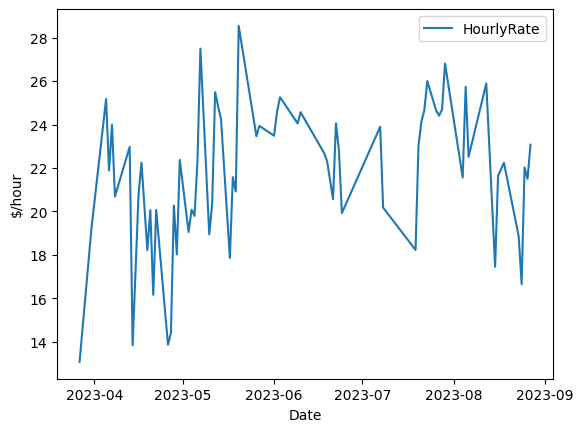

In [35]:
#https://builtin.com/data-science/time-series-python#

plt.ylabel('$/hour')
sns.lineplot(plotDF)
plt.show()

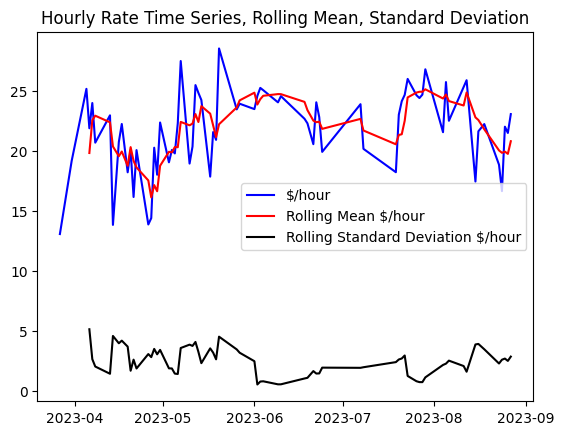

In [36]:
rolling_mean = plotDF.rolling(4).mean()
rolling_std = plotDF.rolling(4).std()

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

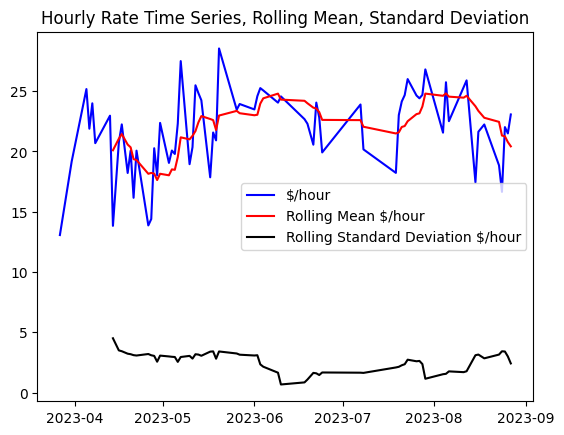

In [37]:
rolling_mean = plotDF.rolling(8).mean()
rolling_std = plotDF.rolling(8).std()

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()


In [38]:
#plt.close() 
from statsmodels.tsa.stattools import adfuller


In [39]:
adft = adfuller(plotDF,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -4.203683              Test Statistics
1   0.000650                      p-value
2   1.000000             No. of lags used
3  69.000000  Number of observations used
4  -3.528890          critical value (1%)
5  -2.904440          critical value (5%)
6  -2.589656         critical value (10%)


In [40]:
autocorrelation_lag1 = plotDF['HourlyRate'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = plotDF['HourlyRate'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = plotDF['HourlyRate'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = plotDF['HourlyRate'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.33461055471745177
Three Month Lag:  0.26174561699636933
Six Month Lag:  0.11196908615715964
Nine Month Lag:  0.08203412525832617


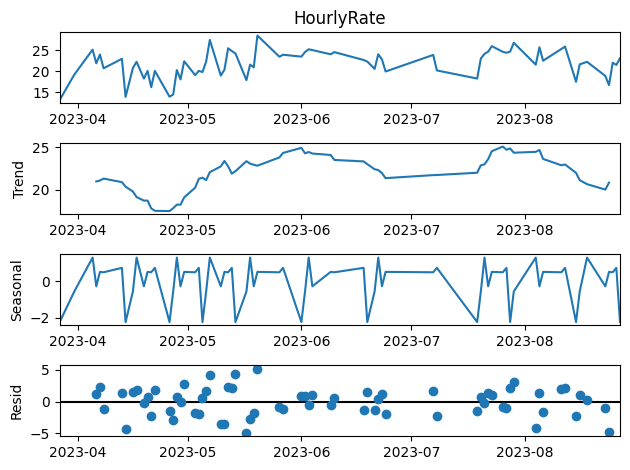

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(plotDF['HourlyRate'],model='additive', period=7)
decompose.plot()
plt.show()

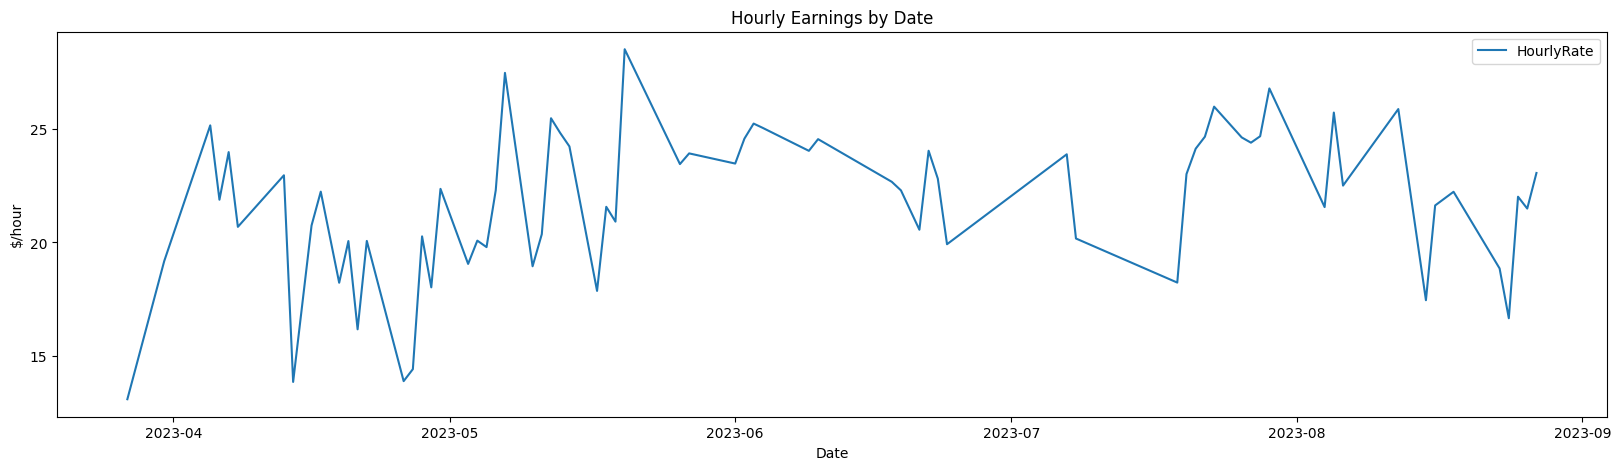

In [42]:
#plt.close() 
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('$/hour')
sns.lineplot(plotDF).set(title='Hourly Earnings by Date')
sns.set_theme(style='white', font_scale=2)
#sns.reset_defaults()
plt.show()

In [43]:
#plt.clf()
#plt.close() 

In [44]:
#plotDF

In [45]:
plotDF = sheets_WeeksDF[["Start Date", "HourlyRate"]].copy()
plotDF.index = plotDF['Start Date']
del plotDF['Start Date']
plotDF

,HourlyRate
Start Date,
3/27,21.745421
4/3,25.107127
4/10,25.778872
4/17,22.785139
4/24,21.158854
5/1,23.397671
5/8,25.594702
5/15,25.286220
5/22,27.493701


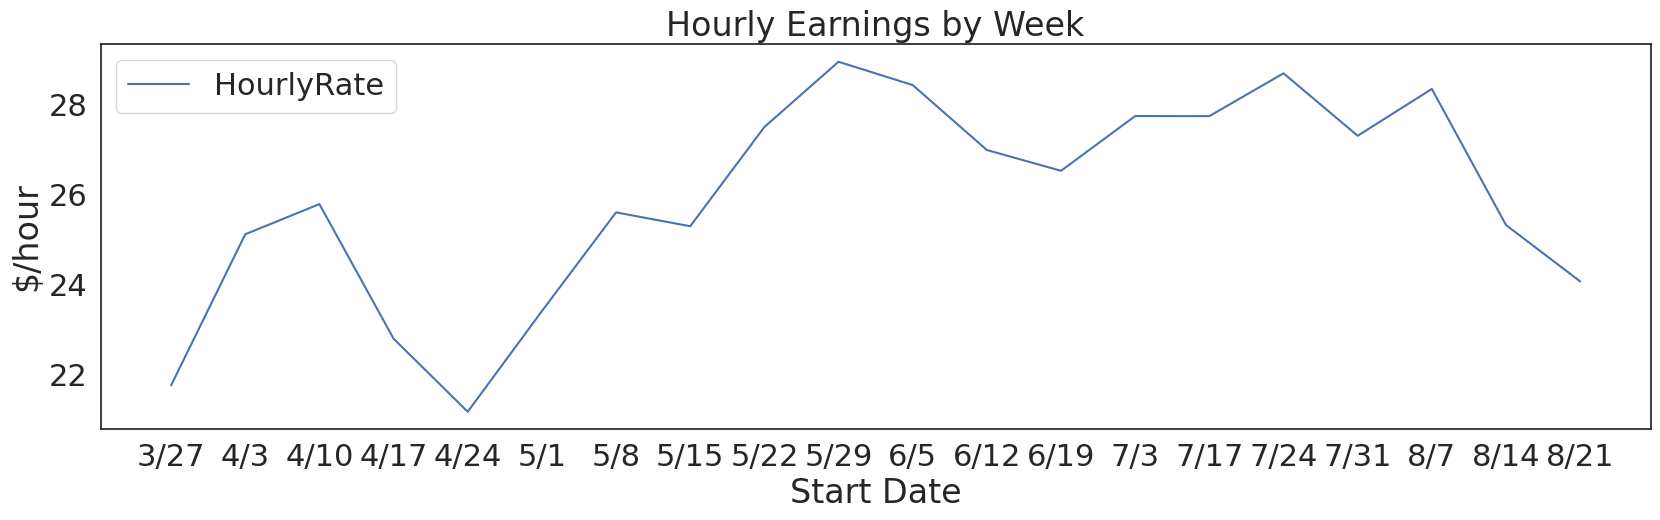

In [46]:
#plt.close() 
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('$/hour')
sns.lineplot(plotDF).set(title='Hourly Earnings by Week')
sns.set_theme(style='white', font_scale=2)
#sns.reset_defaults()
plt.show()

In [47]:
DayOfWeekDF



,Sum Dash,Avg Daily Total,Sum Total,Sum Tip,Sum Deliveries,$/hr,Avg Delivery Tip,Avg Delivery Total
Day of Week,,,,,,,,
Friday,156.67,185.304211,3520.78,1609.53,369,22.47,4.361870,9.541409
Monday,17.85,125.823333,377.47,158.97,41,21.15,3.877317,9.206585
Saturday,125.60,180.356250,2885.70,1281.95,303,22.98,4.230858,9.523762
Sunday,55.33,145.714444,1311.43,604.43,137,23.70,4.411898,9.572482
Thursday,81.96,141.709167,1700.51,716.01,193,20.75,3.709896,8.810933
Tuesday,1.82,31.750000,31.75,14.00,3,17.45,4.666667,10.583333
Wednesday,83.26,141.897273,1560.87,626.37,178,18.75,3.518933,8.768933


In [48]:
plotDF = DayOfWeekDF[["$/hr", "Avg Delivery Tip", "Avg Delivery Total"]].copy()
plotDF = plotDF.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plotDF = plotDF.rename(columns={"$/hr": "Hourly Pay", 
                                "Avg Delivery Tip": "Average Tip", 
                                "Avg Delivery Total": "Average Delivery Total"})

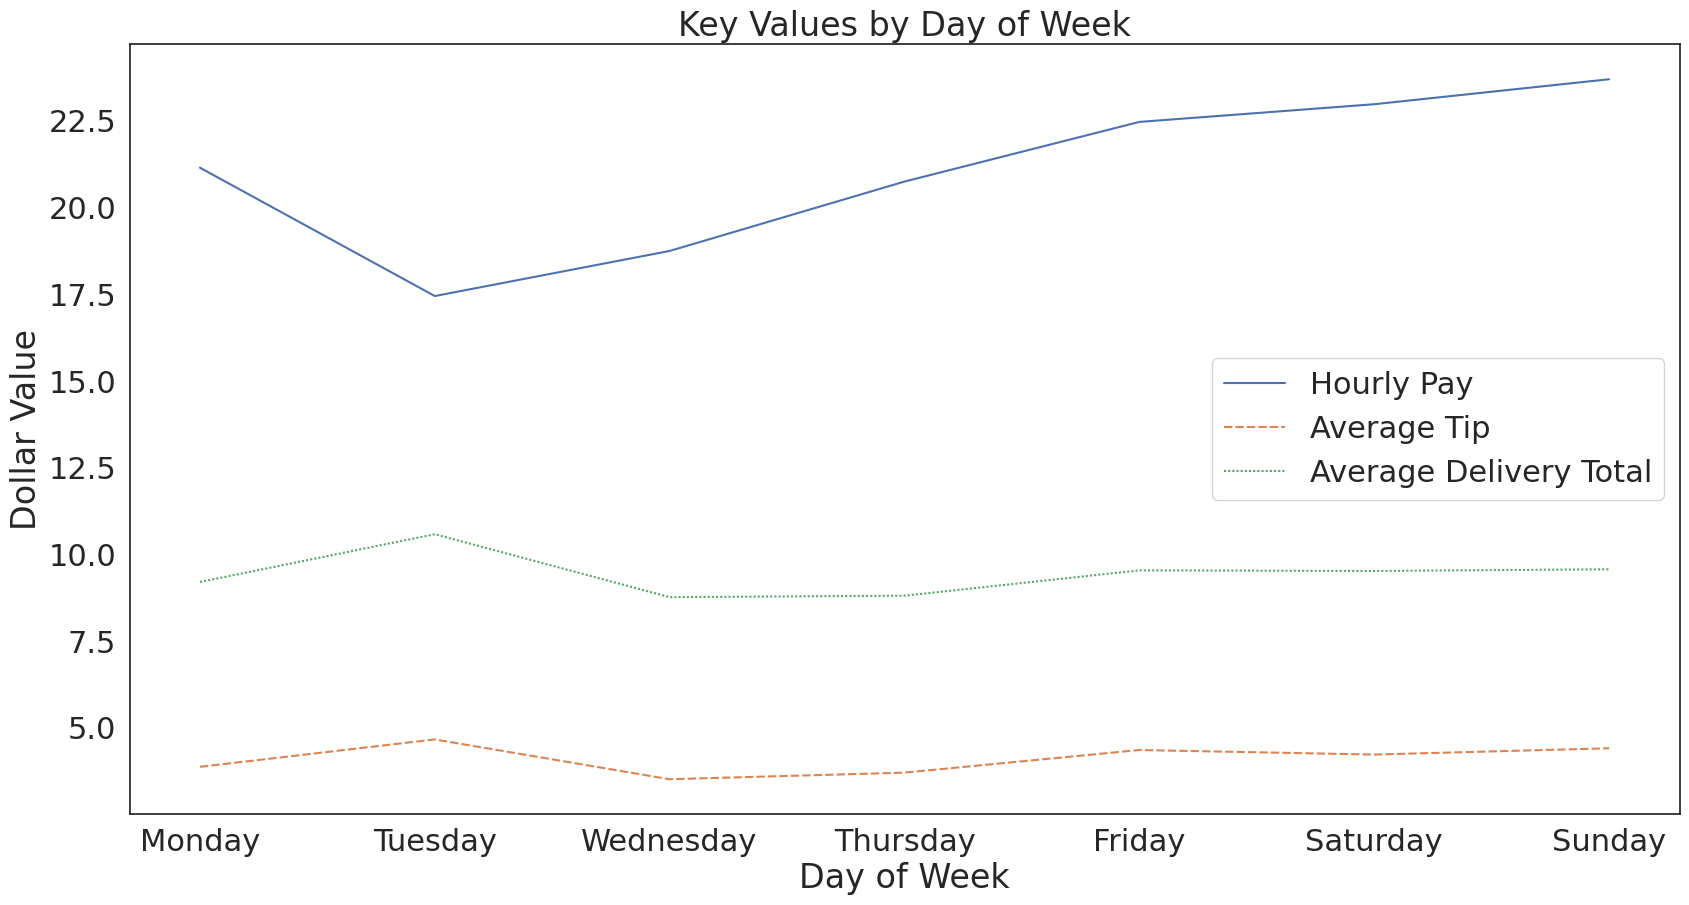

In [49]:
#plt.close() 

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(plotDF).set(title='Key Values by Day of Week')
plt.show()

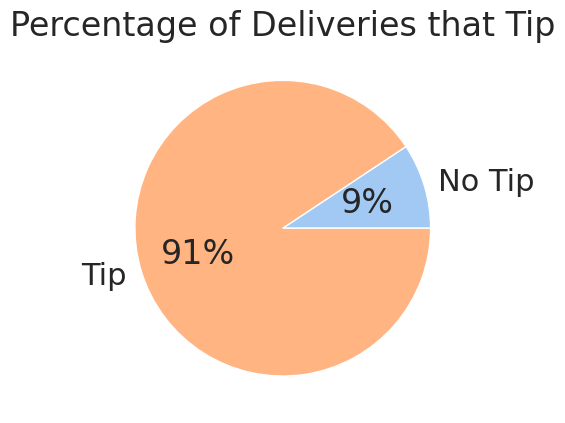

In [50]:
data0 = [numUntipped, numTipped]
labels0 = ['No Tip', 'Tip']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data0, labels = labels0, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Deliveries that Tip')
plt.show()

In [102]:
tempDF = restaurantsDF.sort_values(by=["Sum Total"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Sum Total"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Total"]
leaderTotal = tempDF[["Sum Total"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_5370/913864327.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Sum Total
Restaurant Name,
Chick-fil-A,1302.64
Taco Bell,655.87
McDonald's,618.17
Dave's Hot Chicken,589.00
Chipotle,484.92
All Others,9672.59


In [105]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Sum Total"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '% ($' + str(row["Sum Total"]) + ")"
    overallContribution.append(x)
overallContribution

['9.78% ($1302.64)',
 '4.92% ($655.87)',
 '4.64% ($618.17)',
 '4.42% ($589.0)',
 '3.64% ($484.92)',
 '72.60% ($9672.59)']

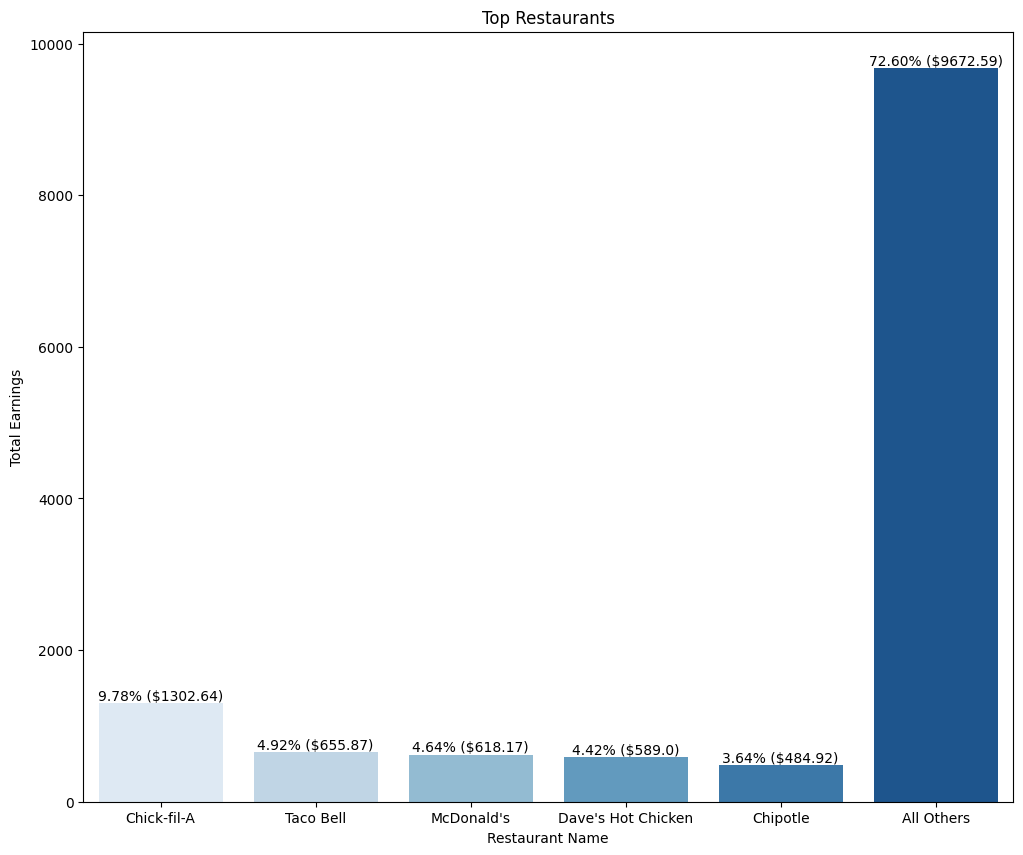

In [108]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x = tempDF.index,
            y = 'Sum Total',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Earnings", title="Top Restaurants")
#for i in ax.containers:
#    ax.bar_label(i,) 
# Show the plot
#ax.bar_label(ax.containers[0])
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [109]:
tempDF = restaurantsDF.sort_values(by=["Deliveries"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Deliveries"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Deliveries"]
leaderTotal = tempDF[["Deliveries"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_5370/920349414.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Deliveries
Restaurant Name,
Chick-fil-A,139
McDonald's,80
Taco Bell,76
Dave's Hot Chicken,62
Chipotle,59
All Others,808


In [110]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Deliveries"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '% (' + str(row["Deliveries"]) + ')'
    overallContribution.append(x)
overallContribution

['11.36% (139)',
 '6.54% (80)',
 '6.21% (76)',
 '5.07% (62)',
 '4.82% (59)',
 '66.01% (808)']

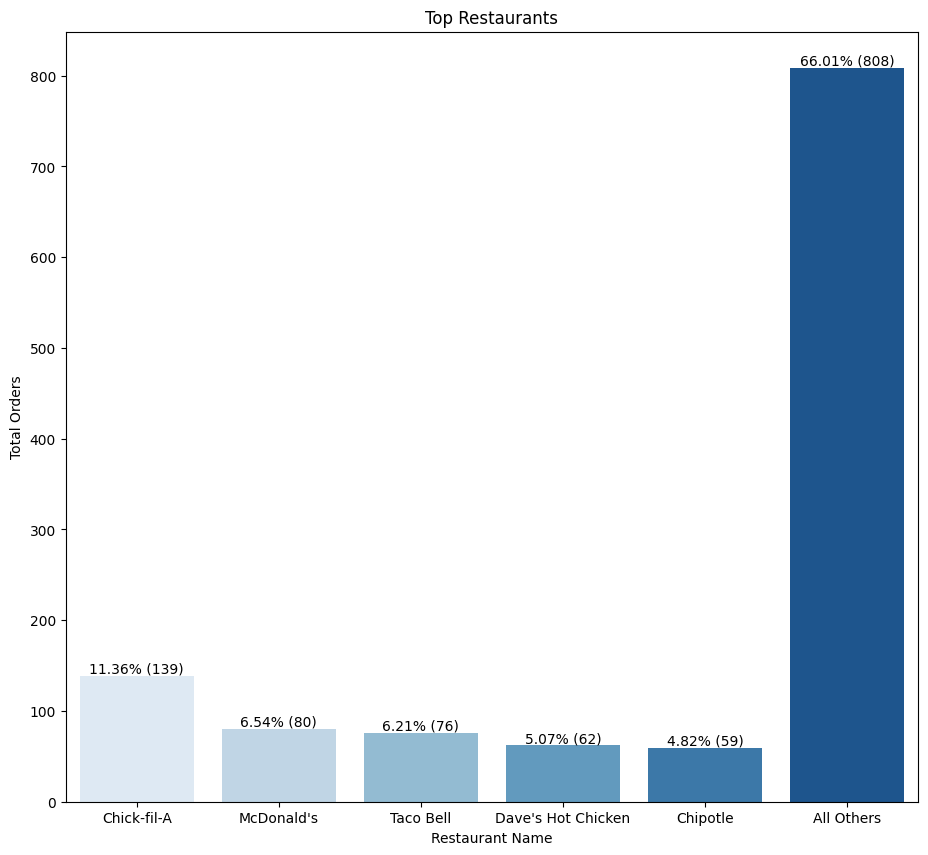

In [111]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(11, 10))
sns.barplot(x = tempDF.index,
            y = 'Deliveries',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Orders", title="Top Restaurants")
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

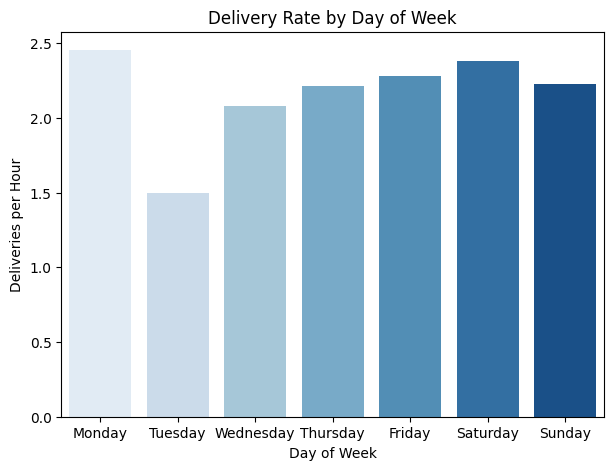

In [57]:
HourlyDelRateDF = sheets_result.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Start Hour": 'size'})
HourlyDelRateDF2 = HourlyDelRateDF.groupby(["Day of Week"]).agg({"Start Hour": "mean"})
HourlyDelRateDF2 = HourlyDelRateDF2.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x = HourlyDelRateDF2.index,
            y = 'Start Hour',
            data = HourlyDelRateDF2,
            palette = "Blues").set(ylabel="Deliveries per Hour", title="Delivery Rate by Day of Week")
#for bars in ax.containers:
#        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [58]:
#sheets_DaysDF.columns
tempDF = sheets_DaysDF.copy()
#newList = []
#tempDF.dtypes
#tempDF.iloc[0]["Date"].month

tempDF["Month"] = tempDF["Date"].dt.month
#tempDF.head()
tempDF = tempDF.groupby(["Month"]).agg({"Total": [np.mean, np.sum],
                                        "Tip": [np.mean, np.sum],
                                       "Active": [np.mean, np.sum],
                                       "Dash": [np.mean, np.sum],
                                       "Deliveries": [np.mean, np.sum],
                                       "HourlyRate": [np.mean],
                                       "ActiveMileage": [np.mean, np.sum],
                                       # "Total Mileage": [np.mean, np.sum],
                                       "Est Adj": [np.mean, np.sum]})
tempDF

#We need to convert - to 0 from Total Mileage values

Total                 Tip             Active              Dash  \
             mean      sum       mean      sum      mean     sum      mean   
Month                                                                        
3       98.250000   196.50  44.000000    88.00  3.345000    6.69  5.475000   
4      122.497647  2082.46  51.468235   874.96  4.121765   70.07  6.275294   
5      207.975000  3327.60  90.100000  1441.60  6.380000  102.08  9.425625   
6      197.030000  2364.36  89.259167  1071.11  6.347500   76.17  8.584167   
7      144.295455  1587.25  67.272727   740.00  4.397273   48.37  6.042727   
8      140.795385  1830.34  61.199231   795.59  4.483077   58.28  6.505385   

              Deliveries      HourlyRate ActiveMileage           Est Adj  \
          sum       mean  sum       mean          mean    sum       mean   
Month                                                                      
3       10.95  11.000000   22  16.119805           NaN    0.0        NaN   
4      106.68  13.823529  235  19.703374           NaN    0.0        NaN   
5      150.81  22.125000  354  22.430972     78.700000  157.4  28.858000   
6      103.01  20.750000  249  23.278021     77.375000  928.5  32.791667   
7       66.47  15.000000  165  23.698740     56.009091  616.1  21.171273   
8       84.57  15.307692  199  21.880258     55.638462  723.3  20.016308   

                
           sum  
Month           
3        0.000  
4        0.000  
5       57.716  
6      393.500  
7      232.884  
8      260.212

In [59]:
#So we have average daily total, monthly total, 
#average daily tip, monthly total tip
#average active time, total active time
#average shift time, total shift time
#average daily deliveries, total deliveries
#avg monthly hourly rate
#avg and total active mileage
#avg and total est adj


#We want to normalize some of this, div by time or by delivery count

#HourlyRate is fine
#Delivery Total average is Total.sum/Deliveries.sum
#Tip Total avg is Tip.sum/Deliveries.sum
#Deliveries/Hour is Deliveries.sum/Dash.sum

#tempDF.iloc[0]["Total"]["mean"]
tempDF1 = tempDF.copy()
tempDF1["Average Delivery Total"] = tempDF["Total"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Average Delivery Tip"] = tempDF["Tip"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Deliveries per Hour"] = tempDF["Deliveries"]["sum"] / tempDF["Dash"]["sum"]
#Not sure how to select a multindex, can't do [["hourlyr"]]
#tempDF1[tempDF1.columns[10]] THIS IS SELECTS THE HOURLY RATE COLUMN, DO WE JUST ADD A NEW COLUMN WITH THOSE VALUES?
#We do for now
tempDF1["Hourly Rate"] = tempDF1[tempDF1.columns[10]]


tempDF1 = tempDF1[["Average Delivery Total", "Average Delivery Tip", "Deliveries per Hour", "Hourly Rate"]]
#tempDF1.dtypes

#This is lazy, should either get dt.month name somehow, check datetime options
#or func to convert num to string, dont hardcode
#tempDF1 = tempDF1.reindex(["March", "April", "May", "June", "July", "August"])
new_index = ["March", "April", "May", "June", "July", "August"]
tempDF1 = tempDF1.set_index(pd.Series(new_index))


tempDF1

,Average Delivery Total,Average Delivery Tip,Deliveries per Hour,Hourly Rate
,,,,
March,8.931818,4.000000,2.009132,16.119805
April,8.861532,3.723234,2.202850,19.703374
May,9.400000,4.072316,2.347324,22.430972
June,9.495422,4.301647,2.417241,23.278021
July,9.619697,4.484848,2.482323,23.698740
August,9.197688,3.997940,2.353080,21.880258


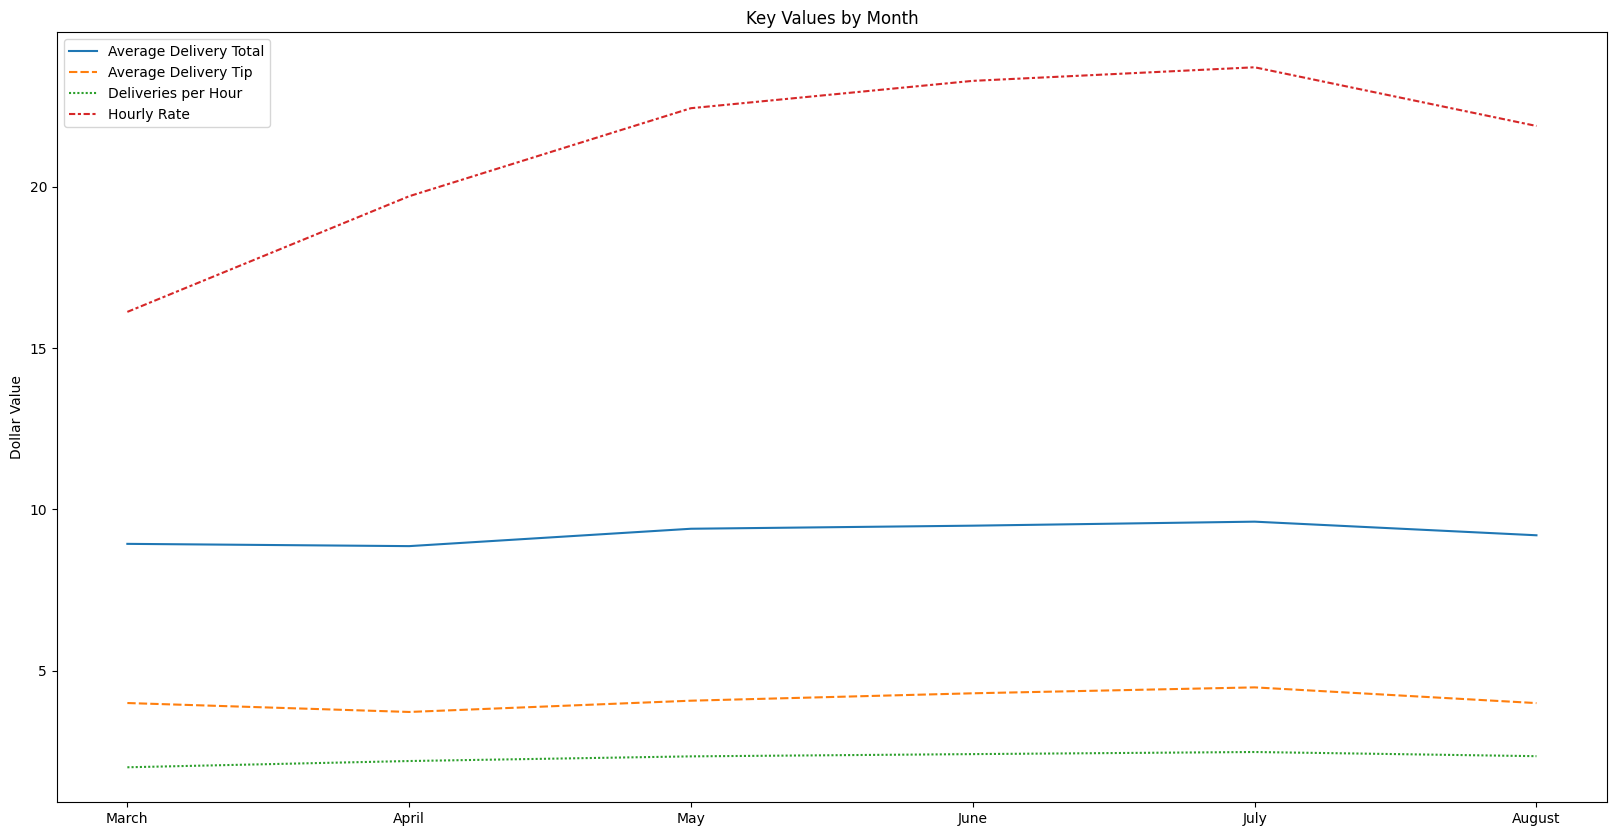

In [60]:


fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(tempDF1).set(title='Key Values by Month')
plt.show()

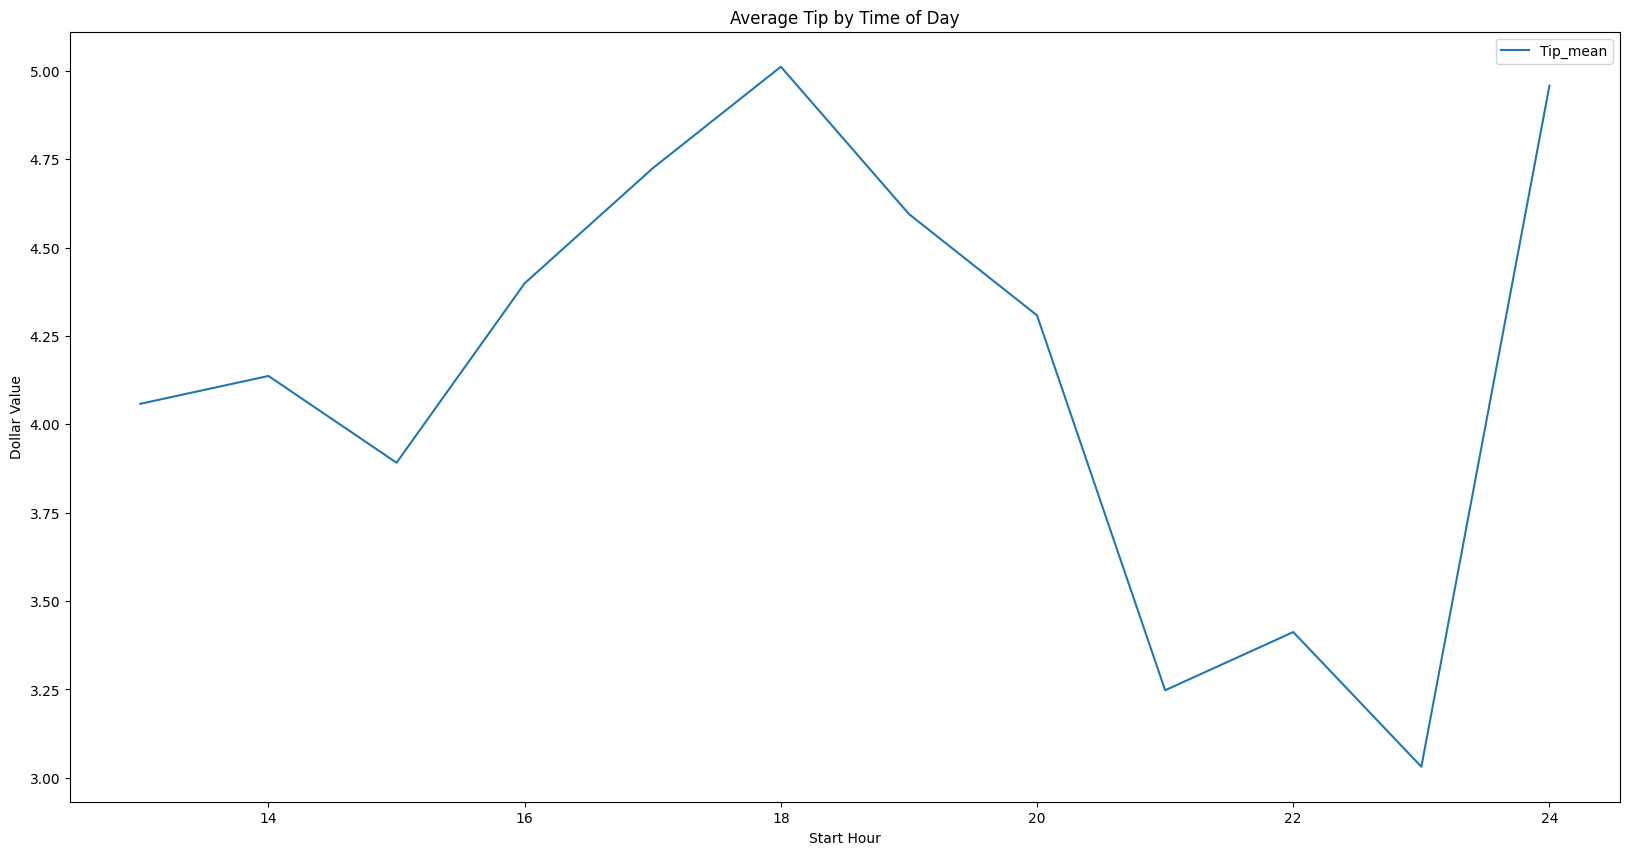

In [85]:
tempDF = sheets_result[sheets_result["Version"]==3].copy()
tempDF0 = tempDF.groupby(["Day of Week", "Start Hour"]).agg({"Total": [np.mean, np.sum],
                                            "Base": [np.mean, np.sum], 
                                            "Tip": [np.mean, np.sum],
                                            "Start Hour": 'size'})
tempDF1 = tempDF.groupby(["Start Hour"]).agg({"Total": [np.mean, np.sum],
                                            "Base": [np.mean, np.sum], 
                                            "Tip": [np.mean, np.sum],
                                            "Start Hour": 'size'})
#tempDF1
#tempDF1 = tempDF1.rename(columns={"$/hr": "Hourly Pay", 
#                                "Avg Delivery Tip": "Average Tip", 
#                                "Avg Delivery Total": "Average Delivery Total"})

#tempDF1.sort_values(by=["Tip"][0])
tempDF1.columns = tempDF1.columns.map('_'.join)
tempDF1 = tempDF1.sort_values(by=["Tip_mean"], ascending=False)
#Dropping the lowest 2 rows because they only include 5 deliveries total
tempDF2 = tempDF1.iloc[:-2]
tempDF2 = tempDF2[["Tip_mean"]]
#tempDF2

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(tempDF2).set(title='Average Tip by Time of Day')
plt.show()

#So 6pm is the best tip time, and we want to look for higher paying orders then
#Also, midnight has great tips, even though 9, 10, 11 are the worst

In [86]:
tempDF1

,Total_mean,Total_sum,Base_mean,Base_sum,Tip_mean,Tip_sum,Start Hour_size
Start Hour,,,,,,,
18.0,10.259468,964.39,5.247340,493.25,5.012128,471.14,94
24.0,9.583333,115.00,4.625000,55.50,4.958333,59.50,12
17.0,10.142632,770.84,5.417763,411.75,4.724868,359.09,76
19.0,9.778171,801.81,5.182927,425.00,4.595244,376.81,82
16.0,9.280789,705.34,4.881579,371.00,4.399211,334.34,76
20.0,9.349529,794.71,5.041176,428.50,4.308353,366.21,85
14.0,10.052000,502.60,5.915000,295.75,4.137000,206.85,50
13.0,9.110000,264.19,5.051724,146.50,4.058276,117.69,29
15.0,9.358913,430.51,5.467391,251.50,3.891522,179.01,46


In [95]:
tempDF = sheets_result.copy()
#tempDF1 = tempDF[tempDF["Stack Encoding"].isnull()]
#tempDF2 = tempDF[tempDF["Stack Encoding"].notnull()]
tempDF1 = tempDF[tempDF["Stacked"] == '']
tempDF2 = tempDF[tempDF["Stacked"] != '']
stackedSum = tempDF2["Total"].sum()
unstackedSum = tempDF1["Total"].sum()
print("Stacked Sum:", stackedSum)
print("Unstacked Sum:", unstackedSum)
stackedPerc = (stackedSum/(stackedSum+unstackedSum))*100
print("% of earnings from stacked orders:", stackedPerc)

Stacked Sum: 2750.86
Unstacked Sum: 8637.65
% of earnings from stacked orders: 24.154696268431955


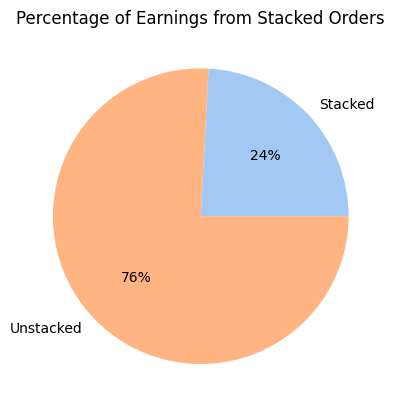

In [97]:
data0 = [stackedSum, unstackedSum]
labels0 = ['Stacked', 'Unstacked']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data0, labels = labels0, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Earnings from Stacked Orders')
plt.show()

In [101]:
tempDF = sheets_result.copy()
tempDF1 = tempDF[tempDF["Base"]==tempDF["Tip"]]
tempDF1.shape
#Okay, 59 orders out of about 1200 isn't exactly a pattern, it appens just under 5% of the time
#Which is neat, but not useful
#Look into other patterns for tipping behavior

(59, 17)

In [61]:
sns.reset_defaults()